# 1. zárthelyi dolgozat, A) változat (2024. 04. 08.)

**Az első zárthelyi dolgozat során egy egyszerű Multi-layer Perceptron (MLP) típusú neuronhálót kell betanítani és kiértékelni egy bináris klasszifikációs feladaton a PyTorch könyvtár segítségével.**

A házi feladat több részfeladatból áll (A - H), melyek egymásra épülnek. A feladat automatikus tesztelőszkripttel rendelkezik és vizsgálja az egyes részfeladatokra adott megoldások helyességét. Éppen ezért, **ne változtasd meg a notebook struktúráját**, ne szedd több részre, illetve ne módosítsd a megírt részeket, csak a megoldásaidat írd be a megfelelő helyre, különben nem fogjuk tudni értékelni! A megoldások az `# Implement your solution BELOW` és `# Implement your solution ABOVE` sorok közé írandók. Ha a megoldott részfeladatok futtatásakor a "Tester: .... OK" felirat megjelenik, a tesztelőszkript nem talált hibát a megoldásban, azonban, a tesztelő nem teljeskörű, nem vesz észre mindenfajta hibát.

**A feladatban elérhető klasszifikációs pontosság:** Körülbelül 85-90% közti (bináris) accuracy érhető el a feladat helyes megoldásával. A konfúziós mátrixnál, ennek megfelelően, a főátlóban többször akkora értékek lesznek, mint azon kívül. Ha ennél jelentősen rosszabb, vagy jelentősen jobb az eredmény, amit a neuronháló legfeljebb elér a teszthalmazon, akkor hibára lehet gyanakodni és meg kell próbálni azt megtalálni: a részfeladatok eredményeit össze lehet például vetni a feladatok szövegével és az eredeti, szöveges fájlban letöltött adatbázissal.

**A megoldott feladatsor beadása:** A kész megoldást tartalmazó notebookot (.ipynb) fájlként kell feltölteni a Canvas-ban, az 1. zárthelyi dolgozat beadási felületén.
**Kérjük a notebook szerkezetét nem módosítani és nem szétszedni külön feladatok szerint!**

**Rendelkezésre álló idő:** 120 perc

**Értékelés:** Legfeljebb 40 pont gyűjthető: lásd a részfeladatokra adható pontokat az egyes feladatoknál. Minimum 20 pontot el kell érni ezen a zárthelyin a tárgy teljesítéséhez - ha ez nem sikerül, javító ZH megírása lesz szükséges.

**Kikötés:** Ahol csak lehet, hatékony, vektorizált megoldásokat várunk. Nagy számú iterációt (50+) végrehajtó ciklus és hasonló, nem hatékony konstrukció a kódban pontlevonást eredményezhet. Részletek a "HF1 GYIK" Canvas fórumon. Kivételek, ahol büntetés nélkül használható hosszabb ciklus:
- Az A) feladatban.
- A háló betanításánál a tanítási/validációs/teszt loopban, akár epoch-ok, akár batch-ek iterálására.


---

Tesztelő szkript betöltése, importok.

In [3]:
import copy
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from annbsc24_p1_zh1a_tester import Tester

## **A**: Az adatbázis betöltése - 4 pont

**Információ az adatbázisról**:
Az adatbázis az UCI Machine Learning Repository "Wine quality" adatbázisa alapján készült. Az adatbázis különböző fehérborok kémiai tulajdonságait tartalmazza (első tizenegy oszlop), valamint öt borszakértő, szubjektív, kóstolás alapján adott értékelését (0-10) a borokra (a maradék öt oszlop, a végén). Egy-egy sorban egy-egy fajta bor adatai találhatók meg.
A zárthelyi dolgozat keretében, **neuronhálóval próbálunk a borok kémiai tulajdonságai alapján becsléseket adni a borszakértők által adott pontszámokra**, így a tanításkor nem látott borokra is tudunk pontszámot becsülni a kémiai összetevőik alapján.

A tesztelőszkript letölti a szöveges formában tárolt adatbázist és elhelyezi a `content` sztringben. Alább, kiírjuk a hosszát és az első 500 karaktert is a sztringből. Az adatbázis fájlok egy-egy sora adja meg az egy-egy mintaelemhez tartozó változók értékeit. A sorokban az egyes változókhoz tartozó értékek vesszővel vannak elválasztva. Az adatbázis első sora a változók neveit tartalmazza.

A feladatod, hogy **alakítsd át a `content` sztringet az adatbázis változóinak értékeit tartalmazó NumPy tömbbé.** A tömbök adattípusa np.float32 (lebegőpontos) legyen! A változók értékeit helyezd el a `dataset_noisy` (n_mintaelem, n_változó) alakú tömbben!  Az input változókat és címkéket később választjuk majd szét.

Az adatbázis helyenként hiányzó értékeket tartalmaz: az adatok egy része nem volt elérhető az adatbázis rögzítésekor. Konkrétabban, a kén-dioxidra vonatkozó méréseket tartalmazó oszlopokban találhatók hiányzó értékek. Ezek az #5 (free sulfur dioxide) és #6 (total sulfur dioxide) indexű oszlopokban találhatók. A hiányzó értékek kötőjellel (`-`) vannak helyettesítve.

A hiányzó értékeket kezelned kell és fel kell ismerned beolvasás közben: a hiányzó értékek helyére a `dataset_noisy` tömbben `np.nan` (Not-a-Number) értékek kell, hogy kerüljenek!

In [4]:
tester = Tester()
content = tester.get_dataset_content()

print("Number of characters in dataset:", len(content))
print(content[:500])


Number of characters in dataset: 306864
"fixed acidity","volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol","score1","score2","score3","score4","score5"
7,0.27,0.36,21.05,0.045,45,170,1.001,3,0.45,8.8,5,6,9,5,4
6.3,0.3,0.34,2.75,0.049,-,-,0.994,3.3,0.49,9.5,5,7,6,7,6
8.1,0.28,0.4,10.10,0.05,30,97,0.9951,3.26,0.44,10.1,7,7,7,6,7
7.2,0.23,0.32,9.93,0.058,47,186,0.9956,3.19,0.4,9.9,6,4,6,6,5
7.2,0.23,0.32,11.75,0.058,47,186,0.9956,3.19,0.4,9.9,7,7


In [50]:
# implement your solution BELOW
lines = content.strip().split('\n')
variables = lines[0].split(',')
dataset_noisy = np.genfromtxt(lines[1:], delimiter=',', dtype=np.float32)

for i in range(dataset_noisy.shape[0]):
    for j in range(dataset_noisy.shape[1]):
        if np.isnan(dataset_noisy[i, j]):
            dataset_noisy[i, j] = np.nan
# implement your solution ABOVE

tester.test('dataset_load', dataset_noisy)

Tester: Dataset loading OK


## **B**: A hiányzó adat kezelése - legfeljebb 3 pont

NaN értékekkel nem fogunk tudni tovább dolgozni, hiszen a legtöbb NumPy/PyTorch művelet nem támogatja őket és bármilyen tömbre, melyben legalább egy NaN érték található, ezen műveletek kimenete is NaN lesz, így például a neuronhálónk becslése és költsége is. Utóbbi megakadályozza, hogy a hálót gradiens módszerrel optimalizáljuk. Éppen ezért, a hiányzó adatokat reprezentáló NaN értékeket az alábbi módon fogjuk eltüntetni:

### **1. (könnyebb) opció** - 1 pont

**Helyettesítsd az összes NaN értéket nullával a tömbben**, majd add értékül a tömböt a `dataset` változónak!

### **2. (nehezebb) opció** - 2 + 1 pont

Helyettesítsd a tömb egyes szóbanforgó oszlopaiban (#5, #6 index) található NaN értékeket **az adott oszlop mediánjával**, majd add értékül a tömböt a `dataset` változónak! A medián kiszámításakor természetesen figyelmen kívül kell hagyni a NaN értékeket.

**+1 pont:** Ha a két oszlopban a NaN értékek helyettesítését logikailag közös utasításokban végzed el, tehát nem oszloponként elkülöníthető kóddal.

**Emlékeztető:** A medián a sorbarendezett értékek közül a középső.

**Emlékeztető:** `np.nan == np.nan` definíció szerint hamis! Az `np.isnan()` függvény alkalmazható a NaN értékek megkeresésére.





In [59]:
# implement your solution BELOW

nan_masks = np.isnan(dataset_noisy[:, [5,6]])
dataset = dataset_noisy.copy()
cols = dataset[:,[5,6]]
cols[nan_masks] = 0
dataset[:,[5,6]] = cols

# implement your solution ABOVE

tester.test('dataset_fill_missing', dataset)

Tester: Dataset fill missing OK


## **C**: Tanító-, validációs- és teszthalmaz szétválasztása - 2 pont

**Keverd meg véletlenszerűen a mintaelemeket** a `dataset` tömbben! Ezt általánosságban azért célszerű megtenni, mert az adatbázisban az elemek valamilyen tulajdonságaik alapján rendezve lehetnek. Megkeverés nélkül, a szétválasztott halmazokban jelentősen különbözne a címkék eloszlása.

Ezt követően **válaszd szét a megkevert tömböt tanító-, validációs- és teszthalmazra**, 70%, 15%, 15% arányban! A halmazokat tartalmazó három tömböt nevezd el `dataset_split_train`, `dataset_split_val`, `dataset_split_test`-nek, sorrendben!

In [52]:
# implement your solution BELOW
np.random.seed(42)
np.random.shuffle(dataset)

n_samples = len(dataset)
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)

dataset_split_train = dataset[:train_size]
dataset_split_val = dataset[train_size:train_size + val_size]
dataset_split_test = dataset[train_size + val_size:]


# implement your solution ABOVE

tester.test('dataset_split', dataset_split_train, dataset_split_val, dataset_split_test)

Tester: Dataset split OK


## **D**: Az adat-iterátorok létrehozása a bináris klasszifikációs feladathoz - 5 + 3 pont

A neuronhálók gradiens módszeres betanítását a legtöbbször iterátorokkal valósítjuk meg, melyek bejárják az adatbázisunkat és előállítják a neuronhálók tanításához szükséges input és címke kötegeket.

**Állítsd elő** a `dataloader_bincl_train`, `dataloader_bincl_val`, `dataloader_bincl_test` nevű **iterátorokat**, melyek a C) részfeladatban elkészült tanító-, validációs- és teszthalmazokat tartalmazó tömböket járják be! A bináris klasszifikációs feladatban input változókként az összes változót felhasználjuk az adatbázisban, kivéve az öt borszakértő által adott pontszámot (`score1`, `score2`, `score3`, `score4`, `score5` nevű, utolsó öt oszlop az adatbázisban). Címkeként két kategóriát definiálunk és ezekbe a kategóriákba az alábbiak alapján sorolunk be borokat az adatbázisból:

- **"Rossz minőségű borok"** kategória, #0 kategóriaindex: Azok a borok, ahol az ötből legalább négy borszakértő jelölt meg 4-es, vagy kisebb pontszámot.
- **"Jó minőségű borok"** kategória, #1 kategóriaindex: Azok a borok, ahol az öt borszakértő által adott pontszámok átlaga legalább 7.

Lesz olyan borfajta (a "határesetek"), ami egyik kategóriába sem kerül be - ezekkel nem foglalkozunk a továbbiakban. Mivel bináris klasszifikációs feladatot oldunk meg, **egyetlen valószínűséget fogunk becsülni**, azt, **hogy mekkora valószínűséggel tartozik a "Jó minőségű borok" kategóriába** az adott borfajta.

A fentiek alapján az iterátorok által visszaadott tenzorok alakja `(batch_size, 11)` és `(batch_size, 1)` lesz.
- Az előbbi, az adatbázis összes felhasznált változójának értékét tartalmazza a kategóriákba besorolt mintaelemekre `torch.float32` adattípusban.
- Utóbbi (a címkéket tartalmazó tenzor) a borok kategóriáját fogja tartalmazni (azaz 0 vagy 1 értékeket, `torch.float32` adattípusban - hiszen ezúttal ezeket valószínűségekként értelmezzük).  `batch_size` ezúttal is a kötegben elhelyezett mintaelemek számát adja meg, ez kézzel beállítandó.

Az iterátorok implementációja többféleképpen megoldható, de javasolt a `torch.utils.data` modul `Dataset` és `DataLoader` osztályait felhasználni, vagy szükség esetén származtatni őket.

Figyelj rá, hogy az iterátorok által visszaadott **kötegekben várhatóan vegyesen legyenek mintaelemek mindkét kategóriából!** (Egy lehetséges megoldás erre a véletlen keverés.)

**Vigyázz, az iterátorok által visszaadott tenzoroknak csak az alakját ellenőrzi a tesztelő szkript, a tartalmát nem!**

### **Opcionális**: Az adat kiegyensúlyozása a címkék szerint

Ha egy klasszifikációs adatbázisban a különböző címke kategóriák nem azonos gyakorisággal fordulnak elő, az azon betanuló neuronháló előnyben részesíti a becslés hibájának csökkentését a gyakoribb kategóriáknál és kevésbé tanulja meg jól kezelni a ritkábban előforduló kategóriával rendelkező mintaelemeket. Továbbá, több hagyományos metrika csalóka eredményt ad kiegyensúlyozatlan adatbázis esetén. Például, ha a mintaelemek 70 százaléka az egyik kategóriába esik a kettő közül, akkor, ha a neuronhálónk csak azt tanulja meg, hogy mindig ezt a kategóriát becsülje, akármit is lát az inputon, máris 70 százalékos accuracy értéket érne el. Ha biztosítjuk, hogy a neuronháló betanításkor és kiértékelésekor mindkét kategóriát egyenlő eséllyel lássa a neuronháló, megelőzzük a fent leírt problémákat.

**+1 pont**: Biztosítsd, hogy az iterátorok által visszaadott **kötegekben nagyjából ugyanolyan valószínűséggel forduljanak elő mintaelemek a két kategóriából!** Kizárólag automatikus megoldások érnek pontot, kézzel, előre beállított valószínűségek nem megfelelőek.

Egy lehetséges megközelítés erre a mintaelemek újra-mintavételezése véletlen index tömbök generálásával, lásd pl. `numpy.random.choice()`, `numpy.random.randint()`, `torch.randint()`.

**+1 pont**: A vektorizált implementációért (ha nem mintaelemenként egyesével sorsolsz, hanem akár kötegenként, akár előre elkészíted a teljes adatbázis kiegyensúlyozását).

**+1 pont**: Ha nem dobsz el egyetlen mintaelemet sem a kiegyensúlyozás során.

**Vigyázz, az iterátorok által visszaadott tenzoroknak csak az alakját ellenőrzi a tesztelő szkript, a tartalmát nem!**

In [127]:
# implement your solution BELOW
def find_variable_index(variables, target_variable):
    return variables.index(target_variable) if target_variable in variables else None

score1_column_index = find_variable_index(variables, '"score1"')
score2_column_index = find_variable_index(variables, '"score2"')
score3_column_index = find_variable_index(variables, '"score3"')
score4_column_index = find_variable_index(variables, '"score4"')
score5_column_index = find_variable_index(variables, '"score5"')

def create_dataset_for_classification(array, score1_column_index, score2_column_index, score3_column_index, score4_column_index, score5_column_index):
    target_list = []
    features_list = []
    scores = 0
    for item in array:
        avg = (item[score1_column_index] + item[score2_column_index] + item[score3_column_index] + item[score4_column_index] + item[score5_column_index]) / 5.0
        if  item <= 4:
                scores += 1
        if scores >= 4:
                target_list.append(0)
        elif avg > 7:
            target_list.append(1)

        features = np.delete(item, [score1_column_index, score2_column_index, score3_column_index, score4_column_index, score5_column_index])
        features_list.append(features)

    target_tensor = torch.tensor(target_list, dtype=torch.float32).reshape(len(target_list), 1)
    features_tensor = torch.tensor(np.array(features_list), dtype=torch.float32)
    return torch.utils.data.TensorDataset(features_tensor, target_tensor)

train_dataset_for_cl = create_dataset_for_classification(dataset_split_train, score1_column_index, score2_column_index, score3_column_index, score4_column_index, score5_column_index)
val_dataset_for_cl = create_dataset_for_classification(dataset_split_val, score1_column_index, score2_column_index, score3_column_index, score4_column_index, score5_column_index)
test_dataset_for_cl = create_dataset_for_classification(dataset_split_test, score1_column_index, score2_column_index, score3_column_index, score4_column_index, score5_column_index)

batch_size = 32

dataloader_bincl_train = DataLoader(train_dataset_for_cl, batch_size=batch_size, shuffle=True)
dataloader_bincl_val = DataLoader(val_dataset_for_cl, batch_size=batch_size, shuffle=True)
dataloader_bincl_test = DataLoader(test_dataset_for_cl, batch_size=batch_size, shuffle=False)


# implement your solution ABOVE

tester.test('bincl_iter', dataloader_bincl_train, dataloader_bincl_val, dataloader_bincl_test)

[ 6.        0.29      0.41     15.34      0.048     0.        0.
  0.9937    3.09      0.59     10.966666  9.        9.        8.
  7.        9.      ]
[5.4000e+00 5.3000e-01 1.6000e-01 6.4400e+00 3.6000e-02 3.4000e+01
 1.2800e+02 9.8856e-01 3.2000e+00 5.3000e-01 1.3200e+01 8.0000e+00
 9.0000e+00 9.0000e+00 9.0000e+00 9.0000e+00]
[7.100e+00 2.500e-01 3.900e-01 7.200e+00 3.600e-02 3.000e+01 1.240e+02
 9.908e-01 3.280e+00 4.300e-01 1.220e+01 9.000e+00 9.000e+00 9.000e+00
 9.000e+00 7.000e+00]
[ 7.3      0.28     0.35     2.69     0.054    0.       0.       0.99178
  3.18     0.47    10.7      5.       4.       4.       3.       5.     ]
[6.5000e+00 3.2000e-01 3.4000e-01 9.6600e+00 4.4000e-02 2.7000e+01
 9.1000e+01 9.9184e-01 3.2800e+00 6.0000e-01 1.2000e+01 8.0000e+00
 9.0000e+00 8.0000e+00 9.0000e+00 9.0000e+00]
[ 6.3      0.3      0.91     8.57     0.034    0.       0.       0.99394
  3.39     0.49    11.7      5.       6.       7.       5.       6.     ]
[7.000e+00 3.600e-01 1.400e-01

AssertionError: Size mismatch between tensors

## **E**: A neuronháló definiálása - 3 pont

**Definiáld a bináris klasszifikációs feladathoz alkalmazandó neuronhálót megvalósító osztályt**, mely az általános `torch.nn.Module` osztály leszármazottja, majd példányosítsd azt és add értékül a `bincl_model` nevű változónak a példányt!

A regressziós neuronháló **tartalmazzon 3 teljesen összekötött réteget, sorban 20, 10 és 1 neuronnal és alkalmazza a ReLU aktivációs függvényt a rétegek között!** Alkalmazd a **dropout** technikát a túltanulás enyhítésére! Betanításkor nullázd ki a ReLU aktivációs függvények kimeneteként kapott vektorreprezentációk egyes elemeit 10% valószínűséggel! (Azaz, két dropout "rétegre" lesz szükséged a ReLU-k után.)

Az új osztálynak mindenképpen meg kell valósítania a `forward(self, x)` tagfüggvényt, mely a neuronhálót (hipotézisfüggvényt) az `x` input tenzorra kiértékeli. A `forward` függvény fogja majd az előbb definiált adat-iterátorból érkező input tenzorokat megkapni és előállítani belőle a címkebecsléseket. Az osztály konstruktorában célszerű a neuronhálónk rétegeit inicializálni.

**Emlékeztető:** Figyelj oda rá, hogy a dropout csak betanítás közben működjön! (Előadáson volt róla szó.)

In [116]:
# implement your solution BELOW

class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_layers = nn.Sequential(
            nn.Linear(11, 20),
            nn.ReLU(),
            nn.Dropout(p = 0.1),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Dropout(p = 0.1),
            nn.Linear(10, 1))

    def forward(self, x):
        return self.linear_relu_layers(x)

bincl_model = ClassificationModel()

# implement your solution ABOVE

tester.test('bincl_model_architecture', bincl_model)

Tester: Binary classification model architecture OK


## **F**: A háló betanítása bináris klasszifikációs feladatra - 9 pont

- **Tanítsd be a** `bincl_model` **neuronhálót** a tanítóhalmazon a `dataloader_bincl_train` iterátor segítségével és alkalmazd a `dataloader_bincl_val` iterátort a validációhoz! Az iterátorok egyetlen (akár véletlen sorrendben történő) végighaladása a tanító és validációs adathalmazokon határoz meg egy _epoch_-ot.

  Alkalmazd a betanításhoz a bináris klasszifikációkor szokásosan használt **költségfüggvényt**!

  A betanításhoz válassz egy gradiens módszer alapú **optimalizációs algoritmust** a `torch.optim` modulból (pl. `SGD`, `Adam`, `RMSprop`, stb.), majd válassz egy megfelelő **tanulási rátát** is!

- A tanítást az **early stopping** technika állítsa le! Amennyiben adott számú epoch-on keresztül (`patience`) nem javul a validációs költség, érjen véget a betanítás és **állítsuk vissza a `bincl_model` súlyait abból az epoch-ból, amikor a legjobb volt a validációs költség!** Mindez automatikusan történjen!

- **Mérd le minden epoch-ban a tanító- és a validációs halmazon mért költségeket, majd a tanítás végeztével rajzold ki ezeknek az értékeknek a tanítás során való alakulását egy közös grafikonon!** A grafikonok kirajzolásához használhatod például a `matplotlib` könyvtárat. Figyelj rá, hogy a grafikonon jól látszódjanak a görbék közti eltérések a tanítás végén is! Ha szükséges, beállíthatod ehhez kézzel, hogy az y tengely melyik részét mutassa a grafikon.

  **A grafikonon legyen jelmagyarázat** (legend), mely megmutatja, melyik görbe írja le a tanítási költséget és melyik a validációs költséget!

- A betanítás végeztével **mérd le az átlagos költséget a teljes teszthalmazon** és add értékül a kapott számot a `test_bce` változónak!

- **Számold ki az _accuracy_ (pontosság) metrikát is a teszthalmaz elemein** és add értékül a kapott számot a `test_acc` változónak!! Az _accuracy_ metrika a helyesen klasszifikált mintaelemek arányát adja meg. Például, ha 150 mintaelem kategóriájának becslésekor 75 esetben találtuk el a helyes kategóriát, az _accuracy_ értéke 0.5 lesz. Figyelj oda, hogy a bináris klasszifikációval kompatibilis módon számold ezt ki!

- **Válassz néhány mintaelemet a teszthalmazból** (például a `dataloader_bincl_test` iterátor segítségével) és **adj becslést a címkéjükre** az input változók értékei alapján, majd **írasd ki az egyes mintaelemekre a becsült és az igazi címkéjüket kategóriák formájában** (Például: `Prediction: 1, true label: 0`)! Így példákon is láthatjuk, hogy mennyire ad jó becsléseket a neuronhálónk.



Early stopping triggered after epoch 10. Best validation loss: 0.0


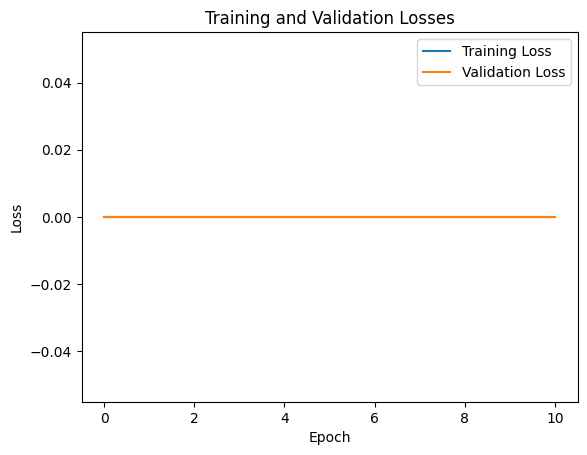


Tester error in test 'bincl_model_learning' ->  Tester: A well trained binary classification model should provide a test loss (BCE) between 0.15 and 0.4.



In [117]:
# implement your solution BELOW
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bincl_model.parameters(), lr=0.001)

patience = 10
best_val_loss = float('inf')
best_epoch = 0

train_losses = []
val_losses = []
for epoch in range(100):
    bincl_model.train()
    train_loss = 0.0
    for inputs, targets in dataloader_bincl_train:
        optimizer.zero_grad()
        outputs = bincl_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(dataloader_bincl_train.dataset)
    train_losses.append(train_loss)

    bincl_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader_bincl_val:
            outputs = bincl_model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
        val_loss /= len(dataloader_bincl_val.dataset)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            torch.save(bincl_model.state_dict(), 'best_model.pth') # Best model
        elif epoch - best_epoch >= patience:
            print(f'Early stopping triggered after epoch {epoch}. Best validation loss: {best_val_loss}')
            break

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()



bincl_model.load_state_dict(torch.load('best_model.pth'))

bincl_model.eval()
test_losses = []
test_correct = 0
test_total = 0
predicted_labels = []
true_labels = []
with torch.no_grad():
    for inputs, targets in dataloader_bincl_test:
        outputs = bincl_model(inputs)
        loss = criterion(outputs, targets)
        test_losses.append(loss.item())
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == targets).sum().item()
        test_total += targets.size(0)
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(targets.tolist())

test_bce = np.mean(test_losses)
test_acc = test_correct / test_total

# implement your solution ABOVE

tester.test('bincl_model_learning', test_bce, test_acc)

## **G**: Konfúziós mátrix - 4 pont

**Számold ki a betanult háló teszthalmazon vett konfúziós mátrixát és rajzold ki azt**! A konfúziós mátrix egy 2 x 2 méretű mátrix lesz ezúttal, ahol az `[i,j]` indexű elem megadja, hogy az adathalmazon a modellünk hány `i` kategóriába tartozó mintaelemet becsült a `j` kategóriába. A modellünk jó teljesítményét jelzi, ha minél több elem kerül a konfúziós mátrix főátlójába. A számoláshoz felhasználhatsz külső könyvtárat is, de NumPy-ban is megoldható. A kirajzoláshoz használható például a `matplotlib.pyplot` csomag `imshow` függvénye.

Figyelj rá, hogy a grafikonon világosan **látszon, hogy melyik tengely sorolja fel az igazi** kategóriákat és **melyik a becsült** kategóriákat, látszanak a sorok és oszlopok végén a **kategóriák indexei** és a cellákban az odatartozó **mintaelemek darabszáma**!

Predicted	True
0		[0.0]
0		[0.0]
0		[0.0]
0		[0.0]
0		[0.0]
0		[0.0]
0		[0.0]
0		[0.0]
0		[0.0]
0		[0.0]


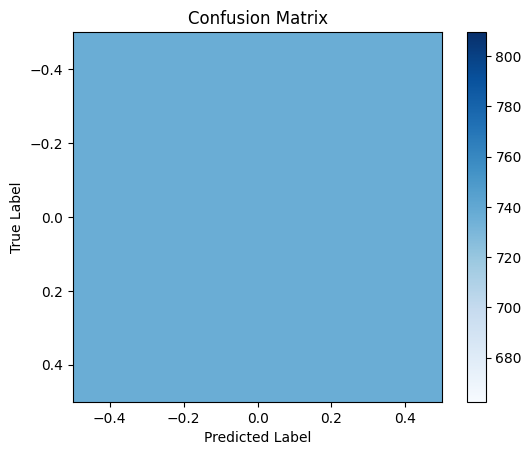

In [118]:
# implement your solution BELOW (No automatic tests for this task)
from sklearn.metrics import confusion_matrix

num_samples = 10
sample_indices = np.random.choice(len(dataloader_bincl_test.dataset), num_samples, replace=False)
print('Predicted\tTrue')
for idx in sample_indices:
    print(f'{predicted_labels[idx]}\t\t{true_labels[idx]}')

cm = confusion_matrix(true_labels, predicted_labels)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()





## **H**: Kétdimenziós hisztogram - 4 + 2 pont

Ebben a feladatban azt fogjuk vizsgálni, hogy milyen mértékben tér el a neuronhálónk által rossz, illetve jó kategóriába becsült borok citromsav és cukortartalma. Vajon szerepet játszhattak-e ezek a tényezők a borszakártők, illetve az általuk adott pontszámok alapján tanult neuronhálónk döntésében?

**Az alábbihoz hasonló grafikont kell elkészítened:**

<br>
<img src="http://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc24_p1/zh1_files/zh1_histogram.png" style="display:inline-block" width='60%'>
<hr>

Válaszd külön a teszthalmaz mintaelemeit aszerint, hogy a neuronhálód azokat a "Rossz minőségű borok", vagy a "Jó minőségű borok" kategóriájába sorolta-e! **Készítsd el a két kategóriákba tartozó mintaelemek kétdimenziós hisztogramját külön-külön!** Legyen a két változó, melynek eloszlását vizsgáljuk a hisztogramban a "citric acid" (#2 indexű oszlop) és "residual sugar" (#3 indexű oszlop) nevű változó!

**Tipp:** A hisztogramok elkészítéséhez javasolt az `np.histogram2d()` függvényt használni. A NumPy dokumentációban, a függvény oldalán találhatók példák is hasonló grafikonokra. A grafikonok elkészítését és kirajzolását javasolt a `matplotlib.pyplot.pcolormesh()` (`plt.pcolormesh()`) függvénnyel elvégezni. A Matplotlib csomag dokumentációjában, az "Examples" fülön számos példa található grafikonokra.

- A grafikonok skáláját úgy határozd meg, hogy a teljes teszthalmaz "beleférjen a képbe" (azaz a hisztogram nullánál nagyobb gyakoriságot jelző cellái mind látszódjanak a grafikonokon)!
- A grafikonoknak legyen különböző címe (Pl. "Rossz minőségű borok", "Jó minőségű borok"), a képen látható módon!
- A grafikonok tengelyei mentén jelöld meg, melyik tengely melyik változó értékeit mutatja!

**+1 pont:** A grafikonok skáláját ne kézzel beállított konstansok adják meg, azaz a tengelyek látható tartományának széleit valamilyen automatikus módszerrel határozd meg!

**+1 pont:** A két grafikon skálája legyen azonos, tehát az egyik grafikonon egy adott (citromsav, cukor) értékekhez tartozó pont a másik grafikonon is ugyanott helyezkedjen el!

(Ne izgulj, az adat manipulált, nem igaz, hogy a száraz borok rossz borok.)






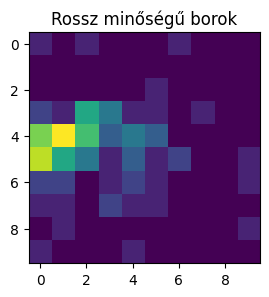

In [119]:
# implement your solution BELOW (No automatic tests for this task)
from matplotlib.image import NonUniformImage
bad_citric = []
bad_residual = []
good_citric = []
good_residual = []
for x, y in dataloader_bincl_test:
    with torch.no_grad():
        y_hat = bincl_model(x)
    for i in range(len(y)):
        if(int(round(y_hat[i].item(),0)) == 0):
            bad_citric.append(x[i][2])
            bad_residual.append(x[i][3])
        else:
            good_citric.append(x[i][2])
            good_residual.append(x[i][3])
             
bad_wines, x, y = np.histogram2d(bad_citric, bad_residual)
good_wines, x, y = np.histogram2d(good_citric, good_residual)

fig = plt.figure(figsize=(30,3))
ax = fig.add_subplot(131, title="Rossz minőségű borok")
fig = plt.imshow(bad_wines)






